## SDM274 Assignment 02 - Linear Regression

**Part I** - Using Python and Numpy, write a class named **LinearRegression**, implementing linear regression model
- Consider MSE loss
- Write three update methods in the class, i.e., SGD, BGD, and MBGD
- Add min-max normalization and mean normalization to the class

Use the following packages mainly:
- Numpy for matrix operations and data manipulation.
- Matplotlib for data visualization.

In [41]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

The **LinearRegression** objects represent linear regression models. Each instanciation requires the following parameters:
- **dim**: the number of features in the dataset
- **learning_rate**: the learning rate in gradient descent
- **max_iteraions**: the maximum number of iterations in gradient descent
- **tolerance**: the tolerance value of the change in the loss function to stop the gradient descent
- **normalization_type**: the normalization type, supporting min-max normalization (NormalizationType.MIN_MAX), and mean normalization (NormalizationType.MEAN) and no normalization (NormalizationType.NONE)
- **optimizer_type**: the optimization algorithm, supporting stochastic gradient descent (OptimizerType.SGD), batch gradient descent (OptimizerType.BGD), and mini-batch gradient descent (OptimizerType.MBGD, **batch_size** needed)
- **batch_size**: the batch size in mini-batch gradient descent

And each object keeps the following attributes:
- **w**: the weights of the linear regression model updating during the training
- **loss_history**: the loss value in each iteration
- **w_history**: the weights in each iteration

Use the method **optimize** to train the model, and the method **predict** to get the prediction.

In [42]:
class OptimizerType(Enum):
    SGD = 1
    BGD = 2
    MBGD = 3

class NormalizationType(Enum):
    NONE = 0
    MINMAX = 1
    MEAN = 2

class LinearRegression:
    def __init__(self, dim = 1, learning_rate = 0.0001, max_iterations = 1000, tolerance = None, normalization_type = NormalizationType.NONE, optimizer_type = OptimizerType.SGD, batch_size = None):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.normalization_type = normalization_type
        self.tolerance = tolerance

        self.optimizer_type = optimizer_type
        self.batch_size = batch_size
        if optimizer_type == OptimizerType.MBGD and batch_size is None:
            raise ValueError("batch_size should be specified for MBGD.")

        self.w = np.zeros(dim + 1)
        
        self.loss_history = None
        self.w_history = None
    
    @staticmethod
    def extend_X(X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def _min_max_normalize(self, X, record_params = False):
        if record_params:
            self.X_min, self.X_max = np.min(X, axis = 0), np.max(X, axis = 0)
        with np.errstate(divide = 'ignore', invalid = 'ignore'):
            X_normalized = (X - self.X_min) / (self.X_max - self.X_min)
        return np.where(np.isnan(X_normalized), X, X_normalized)

    def _mean_normalize(self, X, record_params = False): # TODO
        if record_params:
            self.X_mean, self.X_std = np.mean(X, axis = 0), np.std(X, axis = 0)
        with np.errstate(divide = 'ignore', invalid = 'ignore'):
            X_normalized = (X - self.X_mean) / self.X_std
        return np.where(np.isnan(X_normalized), X, X_normalized)
    
    def _normalize(self, X, record_params = False):
        if self.normalization_type == NormalizationType.MINMAX:
            return self._min_max_normalize(X, record_params)
        elif self.normalization_type == NormalizationType.MEAN:
            return self._mean_normalize(X, record_params)
        return X

    @staticmethod
    def _predict(X, w):
        X_ext = LinearRegression.extend_X(X)
        return X_ext @ w
    
    def predict(self, X, w = None):
        w = self.w if w is None else w
        X_norm = self._normalize(X)
        return LinearRegression._predict(X_norm, w)
    
    @staticmethod
    def _loss(X, t, w):
        return np.mean((t - LinearRegression._predict(X, w)) ** 2)
    
    def loss(self, X, t, w = None):
        w = self.w if w is None else w
        X_norm = self._normalize(X)
        return LinearRegression._loss(X_norm, t, w)

    @staticmethod
    def _gradients(X, t, w):
        X_ext = LinearRegression.extend_X(X)
        return -X_ext.T @ (t - LinearRegression._predict(X, w)) / X_ext.shape[0]
    
    def optimize(self, X, t):
        # Normalization for the first time
        X_norm = self._normalize(X, record_params = True)

        # Initialize history
        if self.tolerance is not None:
            last_loss = np.inf
        self.w_history = []
        self.loss_history = []

        for i in range(self.max_iterations):
            # Select samples
            _X, _t = X_norm, t
            if self.optimizer_type == OptimizerType.SGD:
                indices = np.random.randint(0, _X.shape[0])
                _X, _t = _X[indices:(indices + 1)], _t[indices:(indices + 1)]
            elif self.optimizer_type == OptimizerType.MBGD:
                indices = np.random.choice(_X.shape[0], self.batch_size, replace = False)
                _X, _t = _X[indices], _t[indices]

            # Calculate gradients on the selected samples
            grads = self._gradients(_X, _t, self.w)

            # Update weights
            self.w -= self.learning_rate * grads

            # Calculate overall loss and check convergence
            new_loss = self._loss(X_norm, t, self.w)
            if self.tolerance is not None:
                if np.abs(new_loss - last_loss) < self.tolerance:
                    print(f"Converged at iteration {i}.")
                    break
                last_loss = new_loss

            # Record history
            self.w_history.append(self.w.copy())
            self.loss_history.append(new_loss)

Data splitting utility function **random_split** modified from HA-02.pdf:

In [43]:
def random_split(X, y, test_size = 0.2, seed = None):
    if seed is not None:
        np.random.seed(seed)

    indices = np.arange(len(X))
    np.random.shuffle(indices)

    split_index = int(len(X) * (1 - test_size))
    train_indices, test_indices = indices[:split_index], indices[split_index:]

    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, y_train, X_test, y_test

And finally a utility function **plot_results** to print the optimized results and the closed-form solution, as well as visualize the process of gradient descent, the fitting line, and the loss curve:

In [44]:
def plot_results(model, X, t):
    # Optimization results
    print(f'Optimized results:\t{model.w};')

    # Closed-form solution
    X_norm = model._normalize(X)
    X_ext = LinearRegression.extend_X(X_norm)
    optimal_w = np.linalg.inv(X_ext.T @ X_ext) @ X_ext.T @ t
    print(f'Closed-form solution:\t{optimal_w}.')

    # Plot
    fig = plt.figure(figsize = (30, 9))
    fig.suptitle(f'Linear Regression\n(learning_rate = {model.learning_rate}, max_iterations = {model.max_iterations}, tolerance = {model.tolerance}, normalization_type = {model.normalization_type}, optimizer_type = {model.optimizer_type}{", batch_size = " + str(model.batch_size) if model.optimizer_type == OptimizerType.MBGD else ""})', fontsize = 16)

    # Surface, Descent path & Optimal point
    ax1 = fig.add_subplot(131, projection = '3d')
    margin_ratio = 0.12
    w_history = np.array(model.w_history)
    w0_min, w0_max = np.min(w_history[:, 0]), np.max(w_history[:, 0])
    w1_min, w1_max = np.min(w_history[:, 1]), np.max(w_history[:, 1])
    w0_min, w0_max = min(w0_min, optimal_w[0]), max(w0_max, optimal_w[0])
    w1_min, w1_max = min(w1_min, optimal_w[1]), max(w1_max, optimal_w[1])
    w0_min, w0_max = w0_min - margin_ratio * (w0_max - w0_min), w0_max + margin_ratio * (w0_max - w0_min)
    w1_min, w1_max = w1_min - margin_ratio * (w1_max - w1_min), w1_max + margin_ratio * (w1_max - w1_min)
    w0_mesh, w1_mesh = np.meshgrid(
        np.linspace(w0_min, w0_max, 100),
        np.linspace(w1_min, w1_max, 100)
    )
    loss_mesh = np.zeros_like(w0_mesh)
    for i in range(w0_mesh.shape[0]):
        for j in range(w0_mesh.shape[1]):
            w = np.array([w0_mesh[i, j], w1_mesh[i, j]])
            loss_mesh[i, j] = model.loss(X, t, w)
    ax1.plot_surface(w0_mesh, w1_mesh, loss_mesh, cmap = cm.coolwarm, alpha = 0.6)
    ax1.plot(w_history[:, 0], w_history[:, 1], [model.loss(X, t, w) for w in w_history], 'r-o', markersize = 1)
    ax1.scatter(optimal_w[0], optimal_w[1], model.loss(X, t, optimal_w), color = 'blue', s = 10)
    ax1.set_xlabel('w_0')
    ax1.set_ylabel('w_1')
    ax1.set_zlabel('Loss (MSE)')
    ax1.set_title('Loss Surface & Descent Path')

    # Optimized line
    ax2 = fig.add_subplot(132)
    X_ext = LinearRegression.extend_X(X_norm)
    ax2.scatter(X, t, color = 'blue')
    ax2.plot(X, X_ext @ model.w, color = 'red')
    ax2.set_xlabel('X')
    ax2.set_ylabel('t')
    ax2.set_title('Optimized Line')

    # Loss curve
    ax3 = fig.add_subplot(133)
    ax3.plot(model.loss_history)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Loss (MSE)')
    ax3.set_title('Loss Curve')

    # Show plot
    plt.show()

**Part II** - Test your linear regression model
- Consider the data set generated from the codes in next page
- Adopt the linear regression model
- **(\*1)** Try SGD, BGD, and MBGD and analyze what you observe during training
- **(\*2)** Try using min-max normalization, mean normalization, as well as without normalization, and then analyze what you observe during training
- Use matplotlib to plot the data as well the line learned for all above try

Random data generation modified from HA-02.pdf, and data splitting:

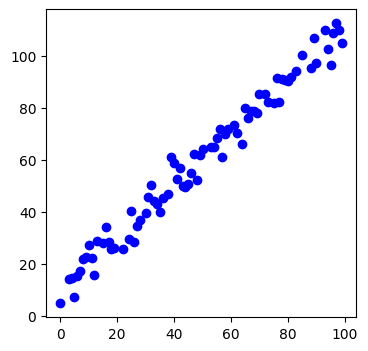

In [45]:
N = 100
X_train = np.arange(N).reshape(N, 1)
a, b = 1, 10
y_train = a * X_train + b + np.random.normal(0, 5, size = X_train.shape)
y_train = y_train.reshape(-1)
X_train, y_train, X_test, y_test = random_split(X_train, y_train, test_size = 0.2, seed = 42)

plt.figure(figsize = (4, 4))
plt.scatter(X_train, y_train, color = 'blue')
plt.show()

**(\*1)** Firstly we train the models using SGD, BGD, and MBGD with mean normalization respectively, and then plot the results. Other parameters are set to be the same.

Converged at iteration 5289.
Optimized results:	[59.76200021 29.25643136];
Closed-form solution:	[59.70802447 28.67704155].


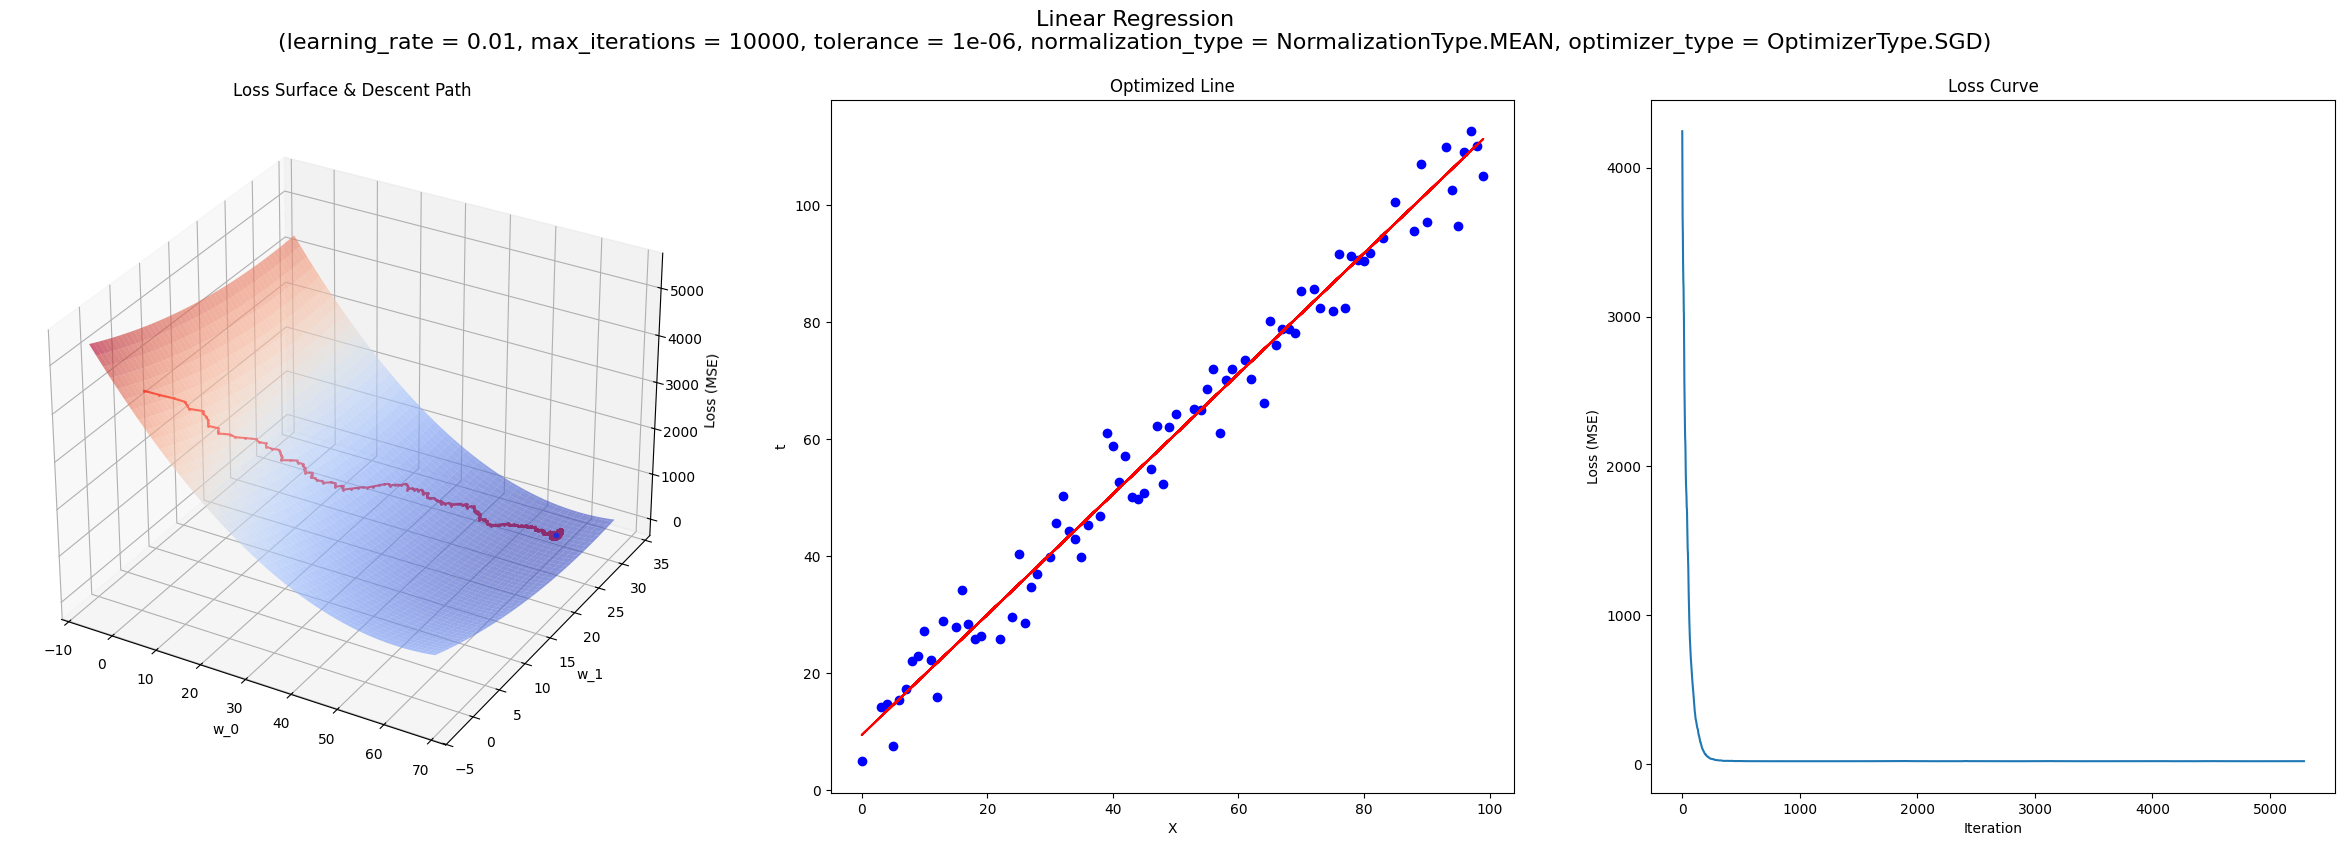

In [46]:
# use SGD
model = LinearRegression(
    dim = 1,
    learning_rate = 0.01,
    max_iterations = 10000,
    tolerance = 1e-6,
    normalization_type = NormalizationType.MEAN,
    optimizer_type = OptimizerType.SGD
)
model.optimize(X_train, y_train)
plot_results(model, X_train, y_train)

Converged at iteration 910.
Optimized results:	[59.70171932 28.67401327];
Closed-form solution:	[59.70802447 28.67704155].


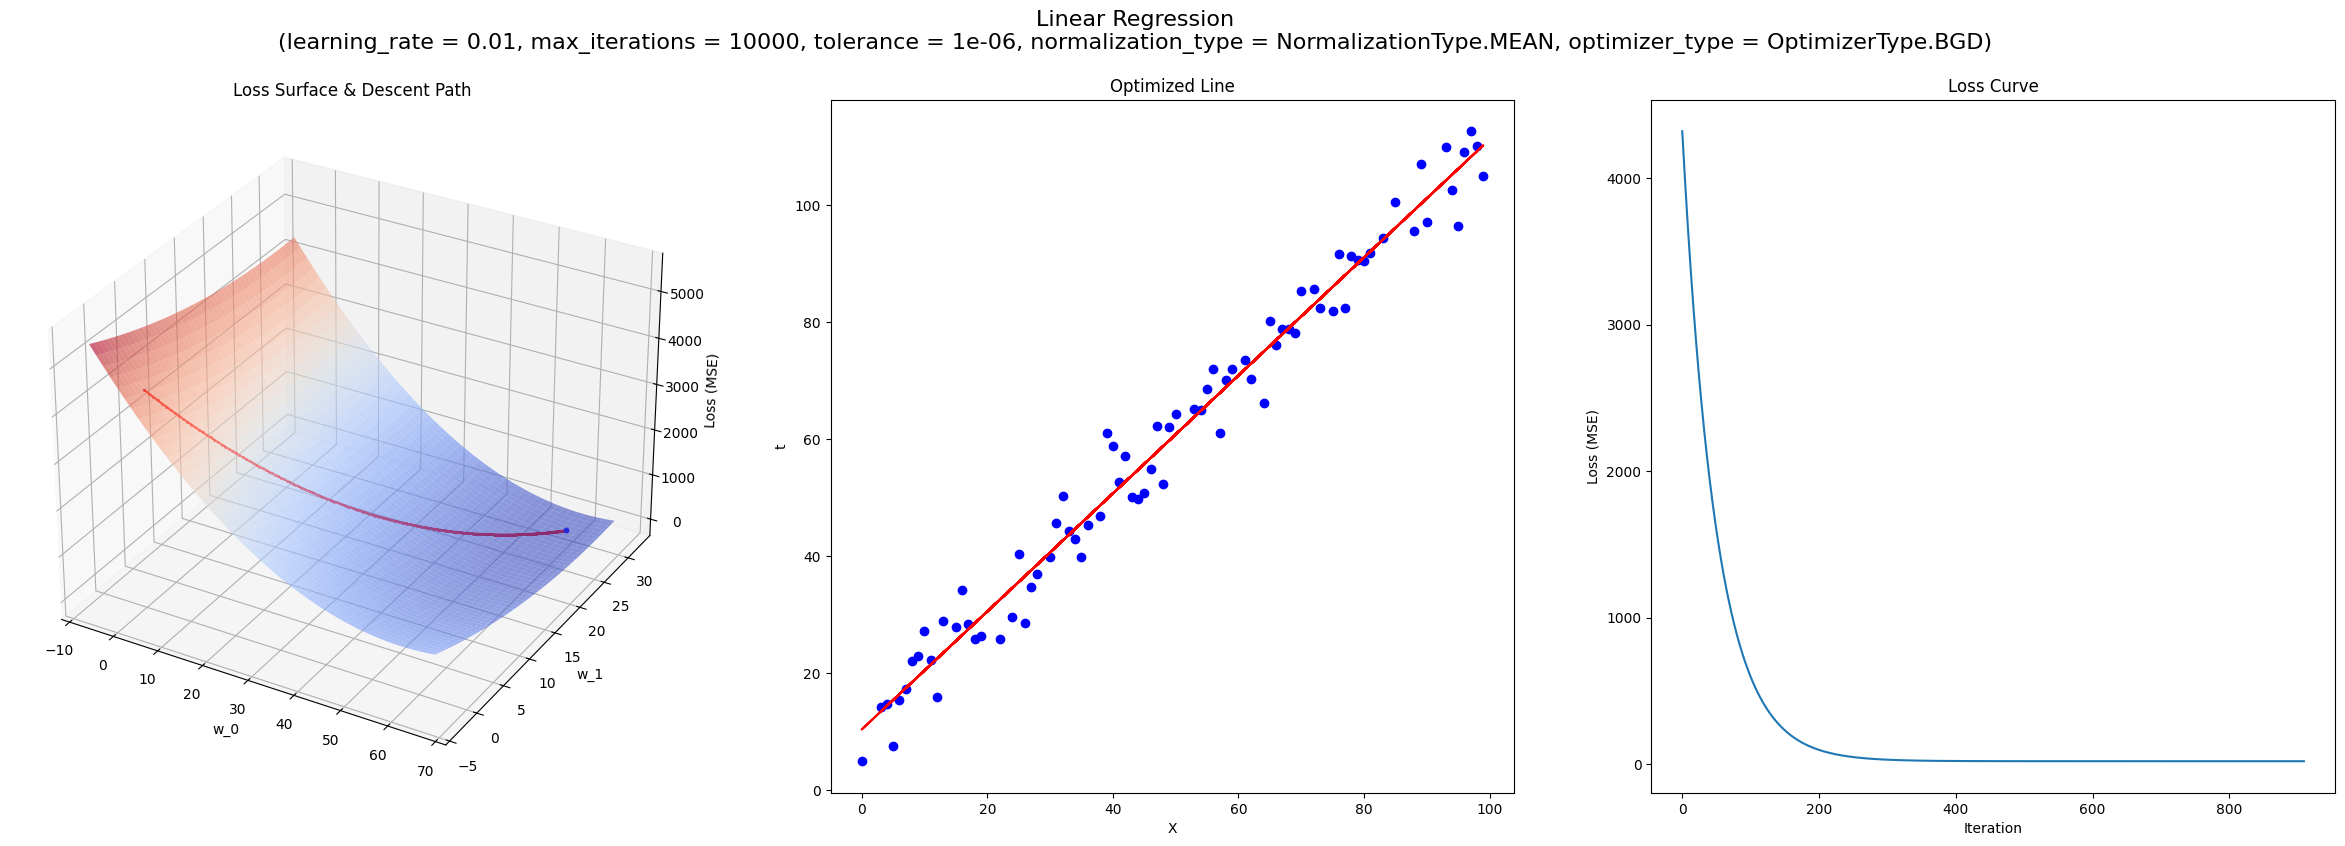

In [47]:
# use BGD
model = LinearRegression(
    dim = 1,
    learning_rate = 0.01,
    max_iterations = 10000,
    tolerance = 1e-6,
    normalization_type = NormalizationType.MEAN,
    optimizer_type = OptimizerType.BGD
)
model.optimize(X_train, y_train)
plot_results(model, X_train, y_train)

Converged at iteration 1943.
Optimized results:	[59.69684003 28.69806961];
Closed-form solution:	[59.70802447 28.67704155].


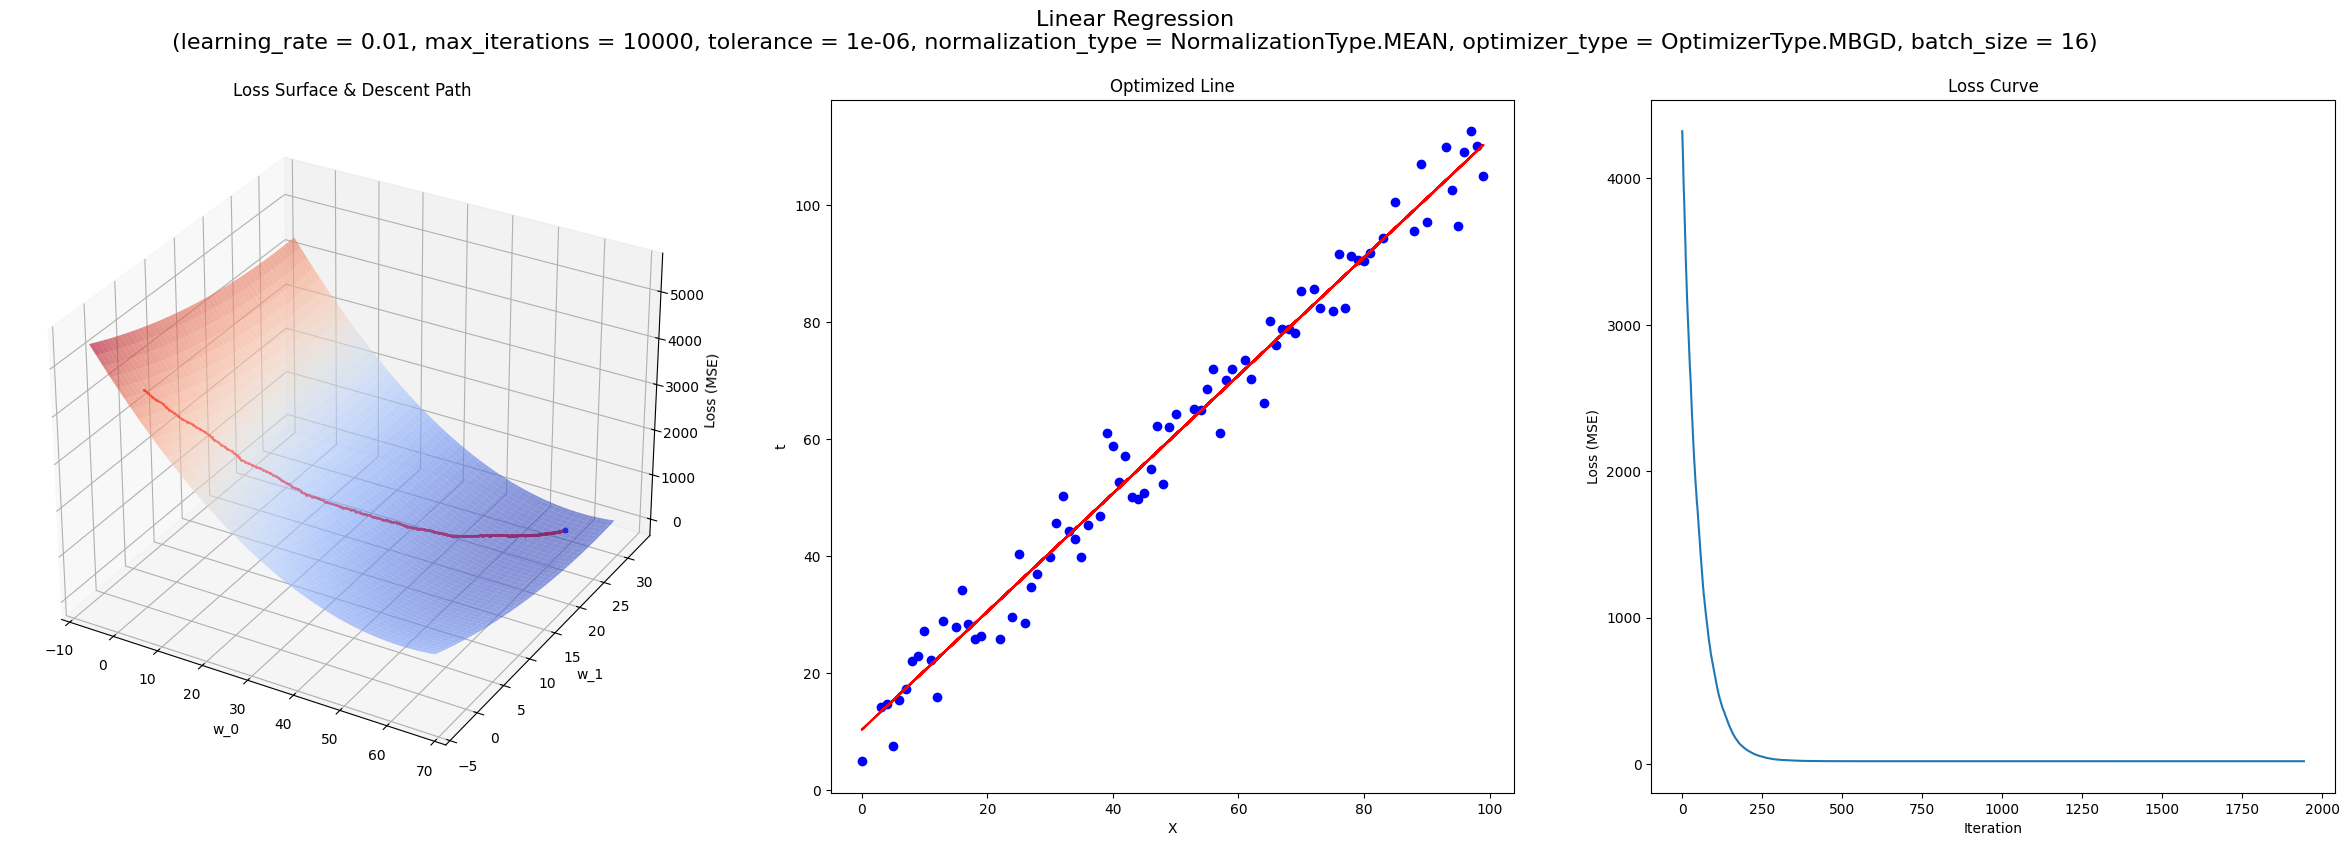

In [48]:
# use MBGD
model = LinearRegression(
    dim = 1,
    learning_rate = 0.01,
    max_iterations = 10000,
    tolerance = 1e-6,
    normalization_type = NormalizationType.MEAN,
    optimizer_type = OptimizerType.MBGD,
    batch_size = 16
)
model.optimize(X_train, y_train)
plot_results(model, X_train, y_train)

TODO: Analysis

**(\*2)** Then we train the models using mean normalization, min-max normalization, and no normalization with BGD respectively, and then plot the results.

Optimized results:	[4.12694954 1.10489911];
Closed-form solution:	[10.37992379  1.0092706 ].


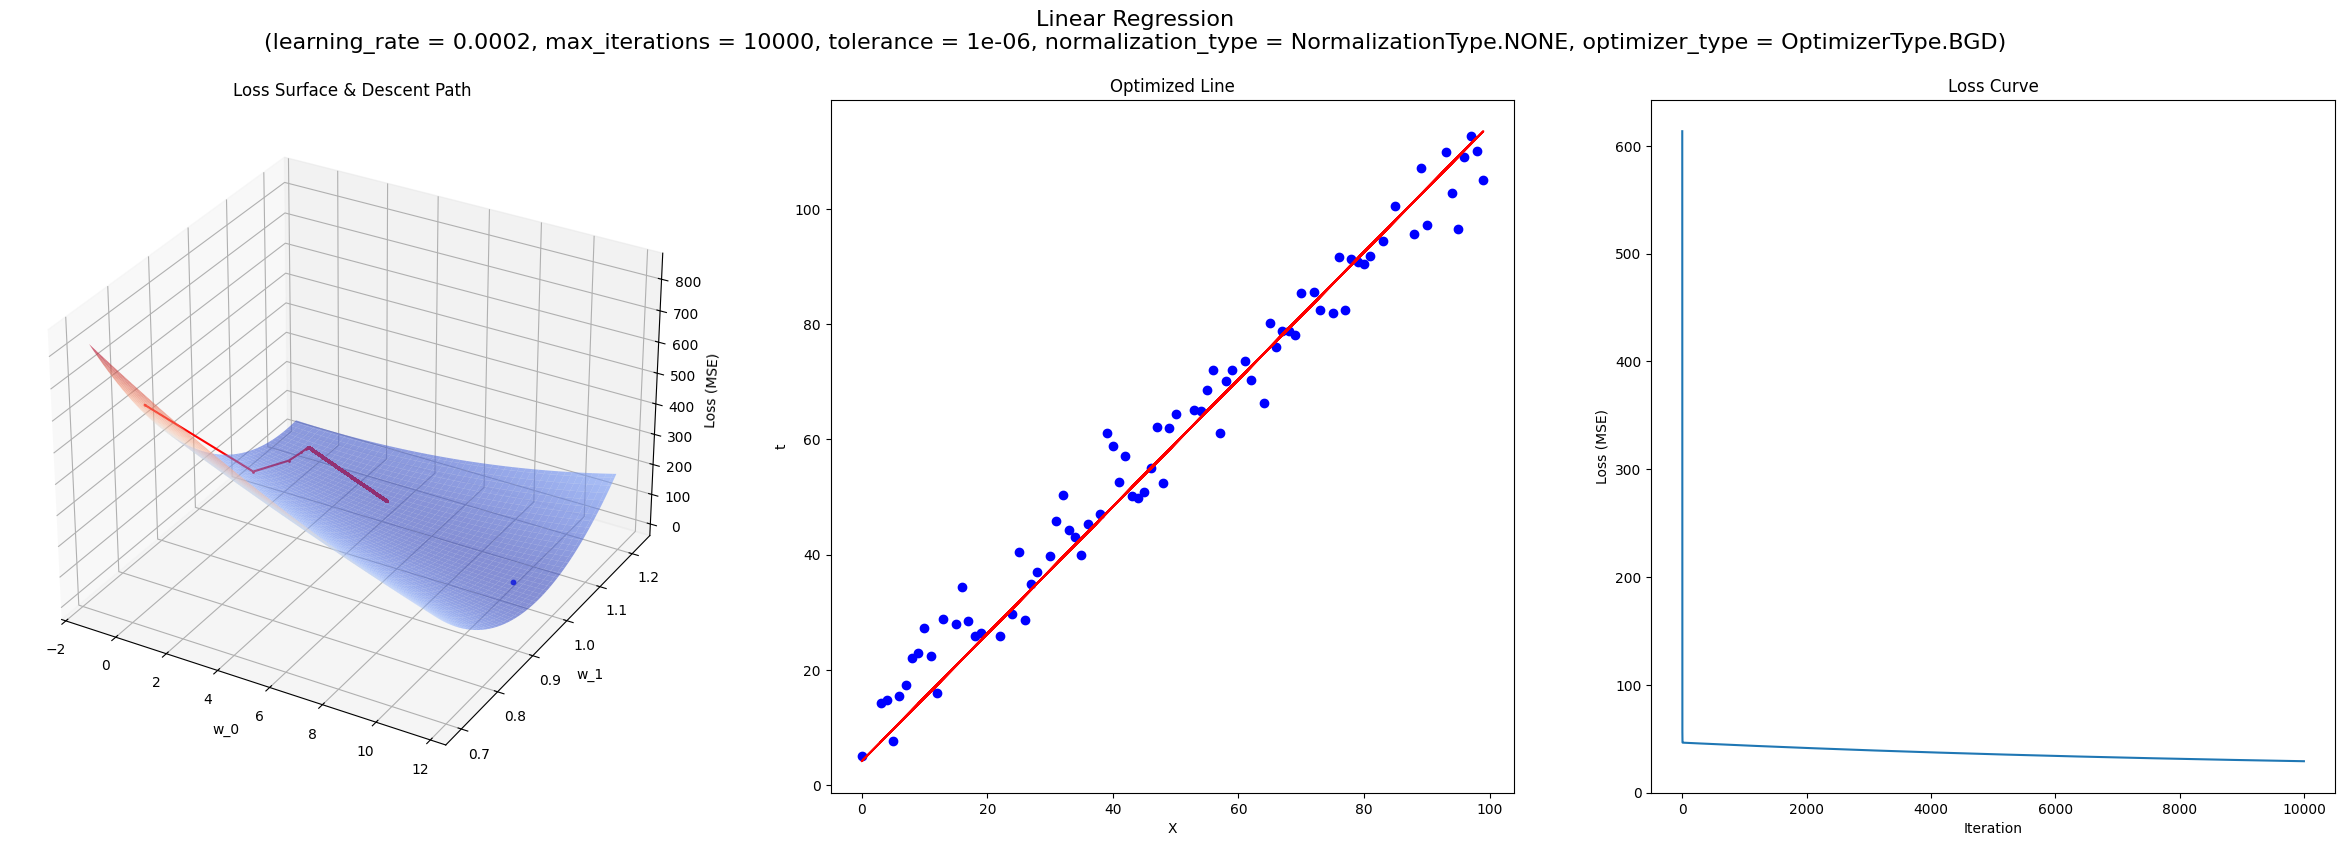

In [56]:
# do not use normalization
model = LinearRegression(
    dim = 1,
    learning_rate = 0.0001,
    max_iterations = 10000,
    tolerance = 1e-6,
    normalization_type = NormalizationType.NONE,
    optimizer_type = OptimizerType.BGD
)
model.optimize(X_train, y_train)
plot_results(model, X_train, y_train)

Optimized results:	[32.91810936 23.35999016];
Closed-form solution:	[10.37992379 99.91778961].


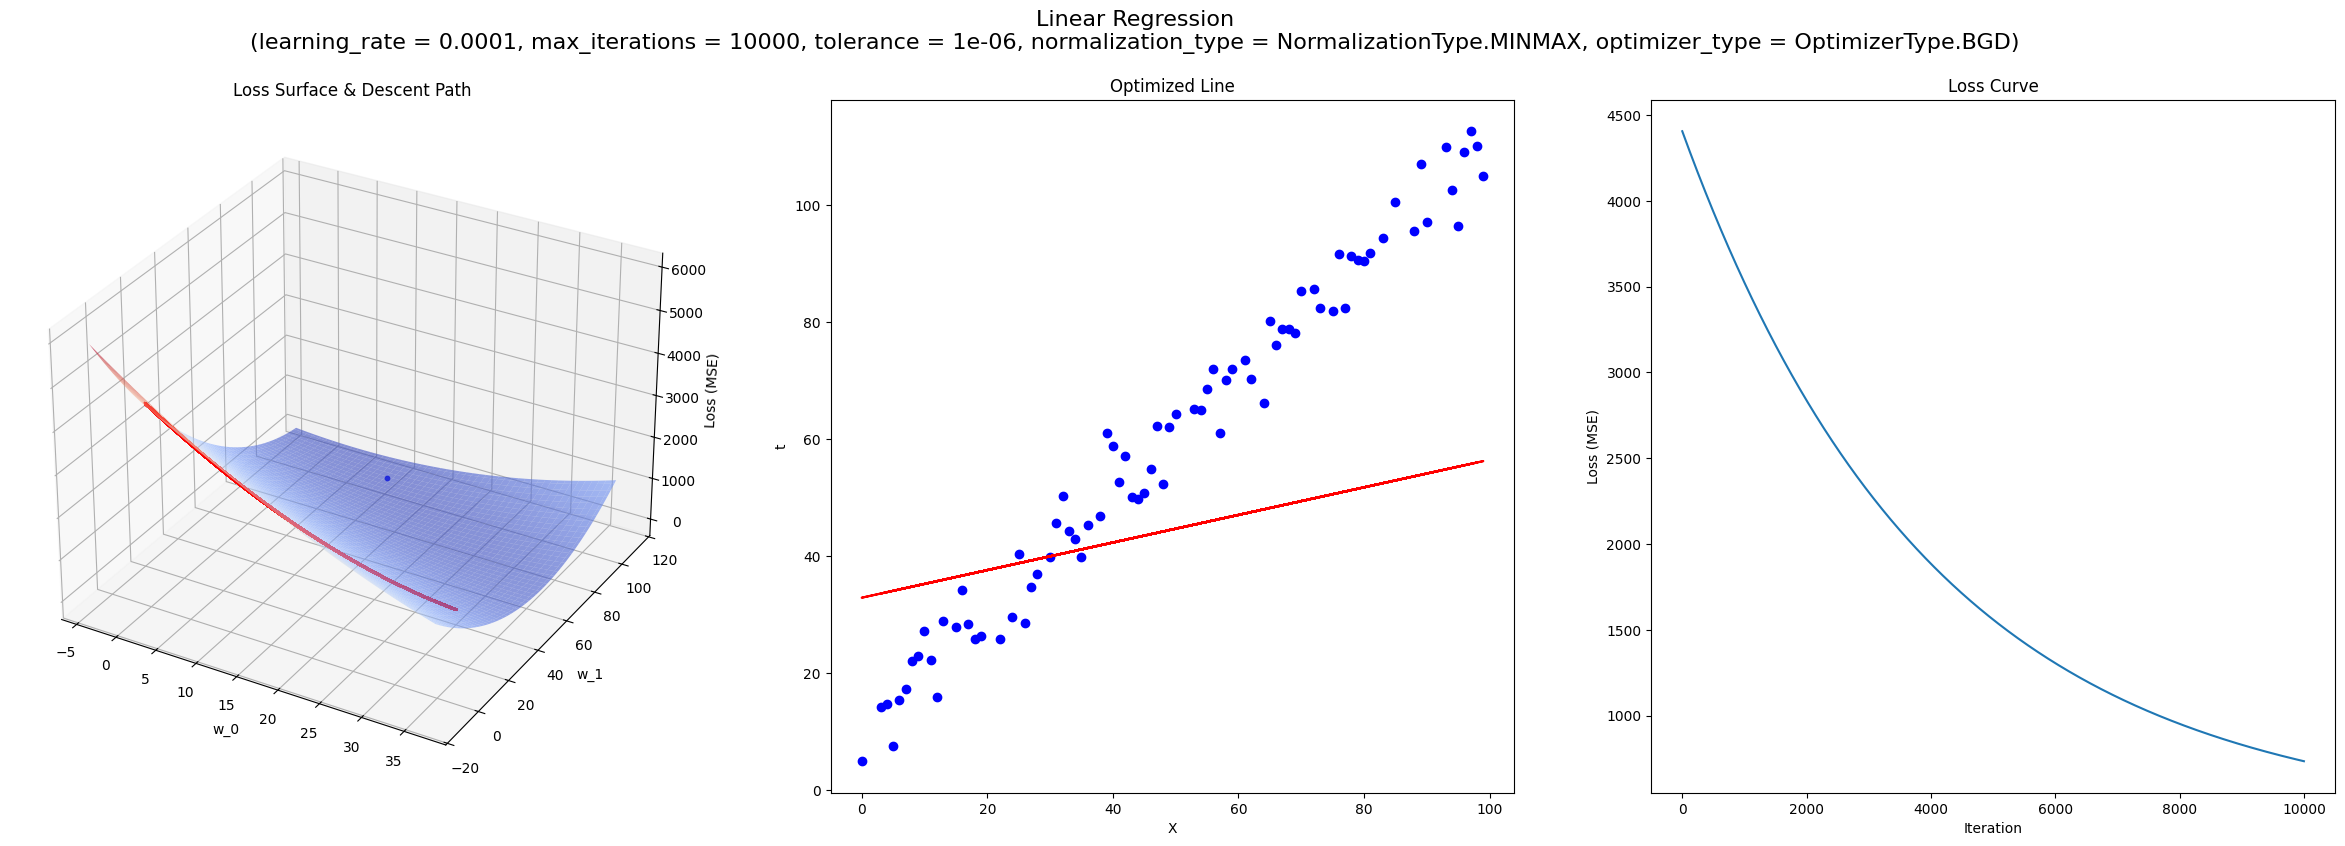

In [50]:
# use min-max normalization
model = LinearRegression(
    dim = 1,
    learning_rate = 0.0001,
    max_iterations = 10000,
    tolerance = 1e-6,
    normalization_type = NormalizationType.MINMAX,
    optimizer_type = OptimizerType.BGD
)
model.optimize(X_train, y_train)
plot_results(model, X_train, y_train)

Optimized results:	[37.74376811 18.12787504];
Closed-form solution:	[59.70802447 28.67704155].


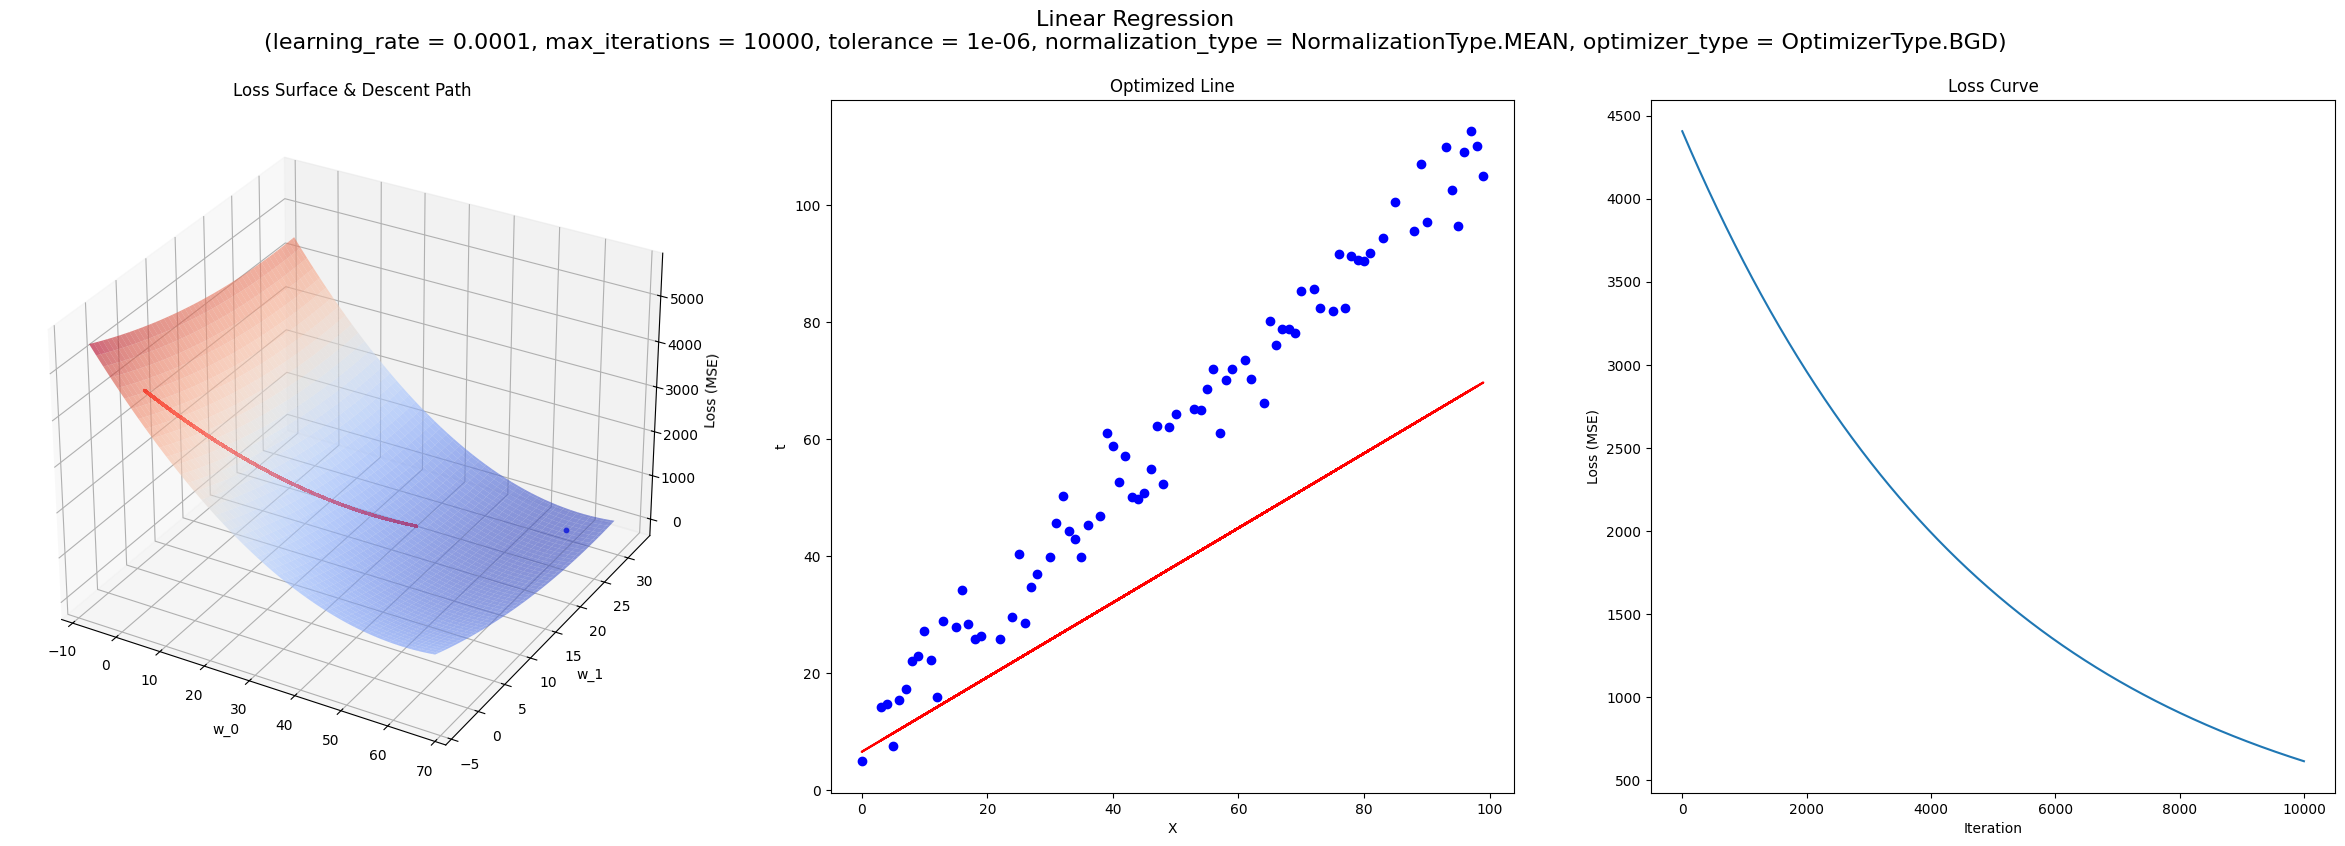

In [53]:
# use mean normalization
model = LinearRegression(
    dim = 1,
    learning_rate = 0.0001,
    max_iterations = 10000,
    tolerance = 1e-6,
    normalization_type = NormalizationType.MEAN,
    optimizer_type = OptimizerType.BGD
)
model.optimize(X_train, y_train)
plot_results(model, X_train, y_train)

**Additional** - Jumping TODO

Optimized results:	[7.44885276 1.0540963 ];
Closed-form solution:	[10.37992379  1.0092706 ].


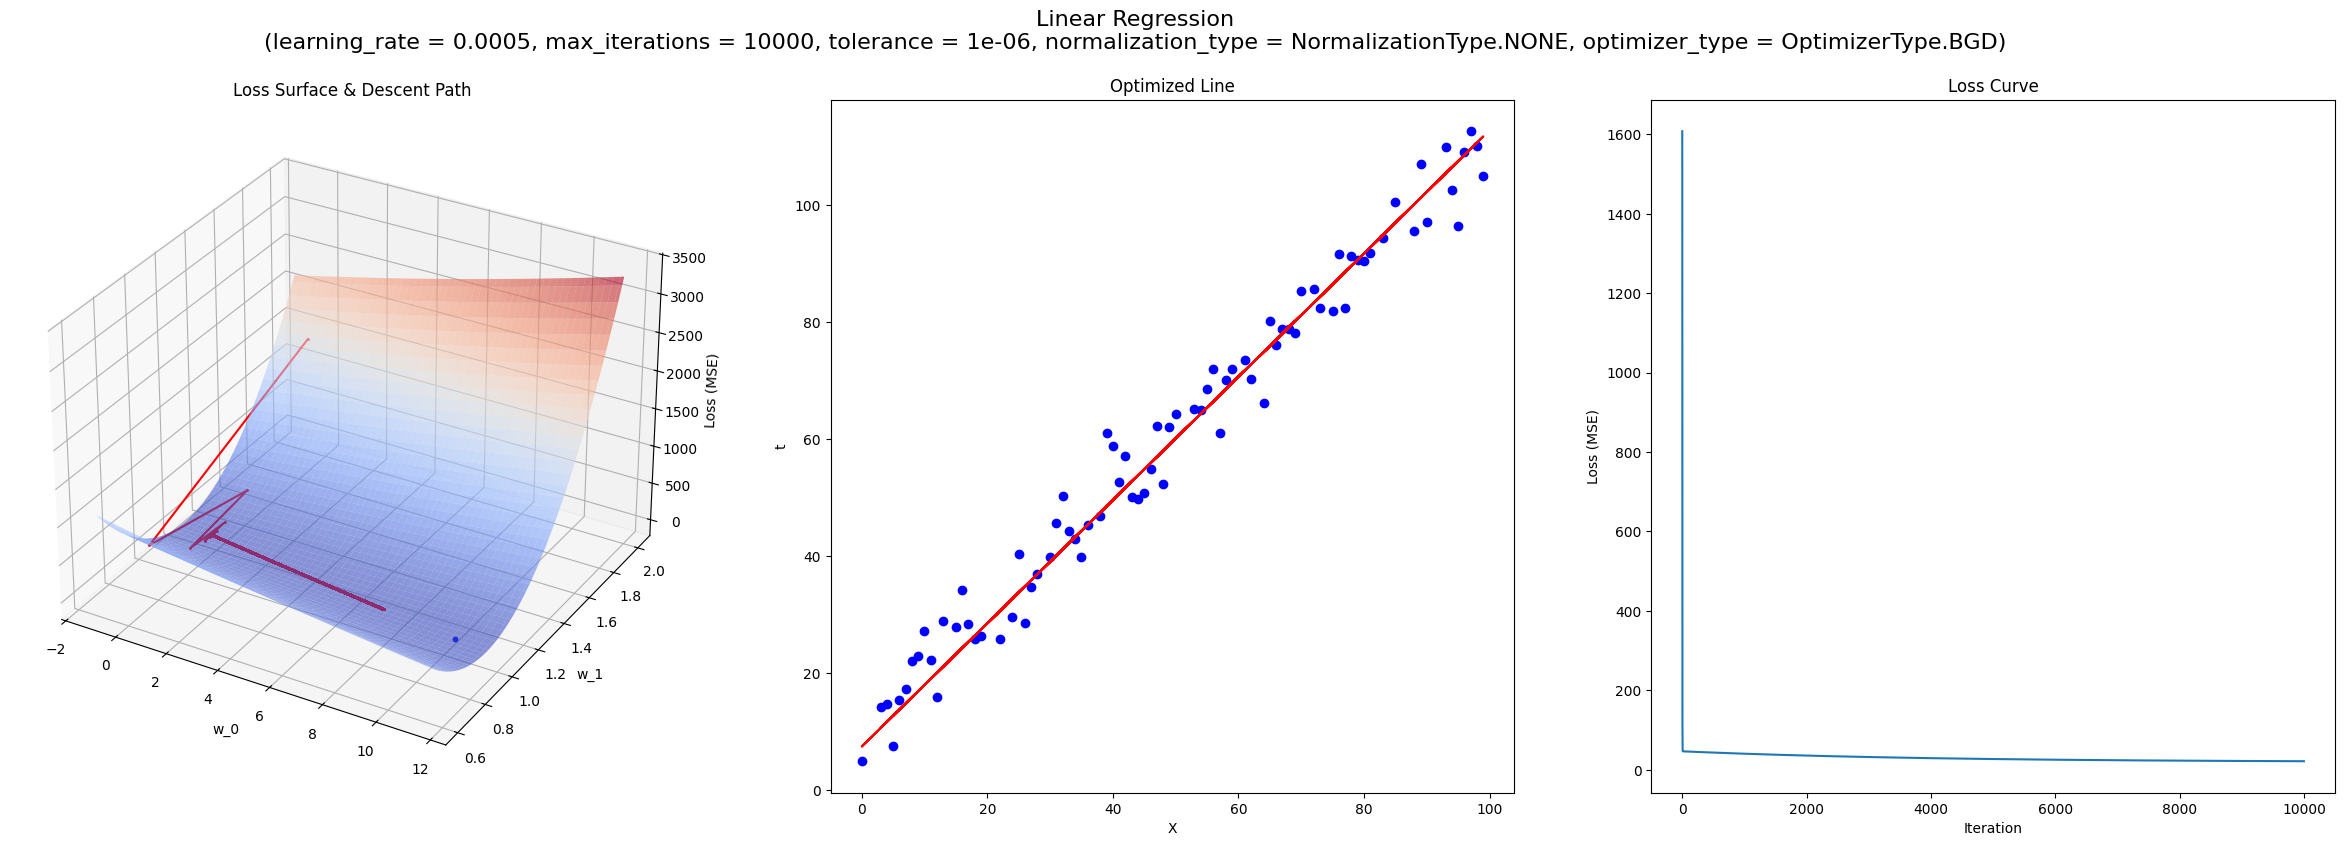

In [61]:
model = LinearRegression(
    dim = 1,
    learning_rate = 0.0005,
    max_iterations = 10000,
    tolerance = 1e-6,
    normalization_type = NormalizationType.NONE,
    optimizer_type = OptimizerType.BGD
)
model.optimize(X_train, y_train)
plot_results(model, X_train, y_train)